#### Author
Victor Aleksandrin

#### Reference
[Notion ticket](https://www.notion.so/a74951e4e815480584dea7d61ddce6cc?v=dbfdb1207d0e451b827d3c5041ed0cfd&p=7fd764a4d88643feb275ff4ab37911c6)

#### Idea
Test different active learning approaches. 

#### Data
4500 cryptonews titles labeled as positive, neutral or negative – zipped pwd-protected [CSV](https://drive.google.com/file/d/1Apr3YPZVf0kOJ5Pc1RYDoQxTdjJPbnt4/view?usp=sharing) (not to be shared outside of the project!)

#### Result
Least confidence, variation ratio and BALD querying strategies perform better than random sampling baseline. Entropy and margin show comparable results. 

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
import yaml

from sklearn.preprocessing import LabelEncoder
from typing import Dict, Any, Tuple, List, Union, Callable

from active_learning_utils.dataset import split_train_val
from active_learning_utils.pipeline import SentimentPipeline
from active_learning_utils.active_learning import (
    RandomSampling, LeastConfidenceSampling, EntropySampling, 
    MarginSampling, VariationRatioSampling, BALDSampling, ActiveLearning
)

import torch
from random import randint

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

import logging
logging.disable(logging.INFO)
logging.disable(logging.WARNING)

### Read data

In [2]:
DATA_PATH = '../data/20190110_train_4500.csv'

In [3]:
dataset = pd.read_csv(DATA_PATH)

In [4]:
dataset.head()

,title,sentiment
0,Bitcoin Market Has Run Out of Juice: Cryptocur...,Negative
1,Bitcoin Core 0.14.0 Speeds Up Blockchain Synci...,Positive
2,Thinking of Travelling With Bitcoin? With Thes...,Positive
3,Investors Carried Out Mental Gymnastics to Jus...,Negative
4,"Bitcoin Price Holds Above $8,500 as Market Fig...",Positive


In [5]:
le = LabelEncoder()

dataset["label"] = le.fit_transform(dataset["sentiment"])

### Config

In [6]:
cfg_str = """
epochs: 3
train_batch_size: 32
val_batch_size: 64
seed: 42

model_name: &model_name distilbert-base-uncased

tokenizer:
    class: transformers.DistilBertTokenizerFast
    params:
        pretrained_model_name_or_path: *model_name
        model_max_length: 50

model:
    class: transformers.DistilBertForSequenceClassification
    params:
        pretrained_model_name_or_path: *model_name
        dropout: 0.2
        attention_dropout: 0.2
        num_labels: 3

optimizer:
    class: transformers.AdamW
    params:
        lr: 0.00005
        weight_decay: 0.001

scheduler:
    params:
        name: linear
        num_warmup_steps: 500
"""

In [7]:
cfg = yaml.safe_load(cfg_str)

### Task description

Our goal is to find the most optimal way to collect unlabelled samples to retrain/finetune our model.


#### Model uncertainty estimation
Using deep neural networks for active learning is hard because they produce over confident output. Also neural networks used for classification are descriminative models and produce only so-called point estimate. Their output is not real probability distribution. One of the possible solutions is to apply Monte Carlo Dropout (MCDO). The idea is to add dropout to the model, perform several forward passes and produce multiple outputs for the same input. As we use pretrained model we simply switch dropout layers into training mode during evaluation to obtain MCDO setting.


#### Approaches
- [Random Sampling (baseline)](#Random-Sampling)
- [Least confidence sampling](#Least-confidence-sampling)
- [Predictive Entropy](#Entropy-sampling)
- [Margin Sampling](#Margin-Sampling)
- [Variation Ratio](#Variation-Ratio)
- [Bayesian Active Learning by Disagreement (BALD)](#BALD)

[**Models comparison**](#Comparison)

#### Evaluation


1. Split dataset on init and pool (80%) and validation part(20%). Then init and pool split on init (20%) and pool (80%).  
2. Use init part to train model and report validation accuracy
3. Employ trained model to predict probabilities for pool data samples.
4. Select 10% of new samples from the pool data to be added to the train dataset. Selection based on choosen active learning strategy
5. Repeat from step 2. Stopping criterion is defined by choosen active learning strategy. By default we continue until pool part is empty


**Evaluation metrics**: Accuracy and Area Under learning Curve (AUC)

#### References
- [Active learning for reducing labeling effort in text classification tasks](https://arxiv.org/abs/2109.04847#:~:text=Active%20learning%20(AL)%20is%20a,Language%20Processing%20(NLP)%2)
- [Overview of Active Learning for Deep Learning](https://jacobgil.github.io/deeplearning/activelearning#learning-loss-for-active-learning)
- [Deep Bayesian Active Learning with Image Data](https://arxiv.org/abs/1703.02910)

### Split dataset

In [8]:
# test_data = unlabelled part
init_pool_data, val_data, _, _ = split_train_val(dataset, test_size=0.2)

In [9]:
init_data, pool_data, _, _ = split_train_val(init_pool_data, test_size=0.8)

In [10]:
len(init_data)

728

In [11]:
len(pool_data)

2915

In [12]:
len(val_data)

911

#### Helpers

In [13]:
def plot(
    x: np.ndarray, 
    scores: Union[List[np.ndarray], np.ndarray], 
    model_name: Union[str, List[str]], 
    title: str = "", 
    color: Union[str, List[str]] = "xkcd:sky blue"
):
    fig, ax = plt.subplots(figsize=(10, 6))
    
    if isinstance(scores, list):
        for i in range(len(scores)):
            ax.errorbar(
                x, 
                scores[i].mean(axis=0), 
                yerr=scores[i].std(axis=0), 
                fmt="o", 
                ls="-", 
                capsize=3, 
                label=model_name[i],
                color=color[i]
            )  
    else:
        ax.errorbar(
            x, 
            scores.mean(axis=0), 
            yerr=scores.std(axis=0), 
            fmt="o", 
            ls="-", 
            capsize=3, 
            label=model_name,
            color=color
        )
    
    ax.set_xlabel("Train size")
    ax.set_ylabel("Validation accuracy")
    ax.legend()
    ax.set_title(title)

In [14]:
def run_exp(
    model_cls,
    model_kwargs: Dict[str, Any],
    init_data: pd.DataFrame, 
    val_data: pd.DataFrame, 
    pool_data: pd.DataFrame,
    repeat_num: int = 1
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    
    scores: List[List[float]] = []
    aucs: List[float] = []
        
    for _ in range(repeat_num):
        model_kwargs["cfg"]["seed"] = randint(0, 100)
        model = model_cls(**model_kwargs)
        
        train_sizes, val_scores = model.train(init_data, val_data, pool_data)
        
        scores.append(val_scores)
        
        auc = np.trapz(
            val_scores,
            train_sizes / np.max(train_sizes)
        )
        
        aucs.append(auc)
    
    return np.array(train_sizes), np.array(scores), np.array(aucs), model

### Experiments setup

In [15]:
NUM_RUNS_PER_EXP = 3
SELECT_TOP_PERCENT = 0.1
NUM_STOCHASTIC_FORWARD_PASSES = 10

### Random Sampling

Idea: Sample random 10% examples from pool set on every step

In [16]:
%%time
%%capture
rs_train_sizes, rs_scores, rs_aucs, rs = run_exp(
    RandomSampling, 
    {"cfg": cfg, "select_top_percent": SELECT_TOP_PERCENT}, 
    init_data, 
    val_data,
    pool_data, 
    NUM_RUNS_PER_EXP
)

CPU times: user 10min 51s, sys: 48.1 s, total: 11min 39s
Wall time: 18min 3s


In [17]:
rs_aucs

array([0.56804486, 0.57344479, 0.58424462])

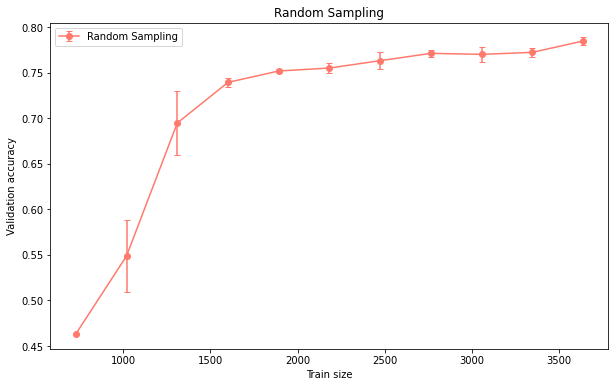

In [18]:
plot(
    rs_train_sizes, 
    rs_scores, 
    model_name="Random Sampling", 
    color="xkcd:salmon", 
    title="Random Sampling"
)

### Least confidence sampling

Idea: sample top 10% least confident examples on every step

In [19]:
%%time
%%capture
lc_train_sizes, lc_scores, lc_aucs, lc = run_exp(
    LeastConfidenceSampling, 
    {
        "cfg": cfg, 
        "select_top_percent": SELECT_TOP_PERCENT, 
        "num_stochastic_forward_passes": NUM_STOCHASTIC_FORWARD_PASSES
    }, 
    init_data, 
    val_data,
    pool_data, 
    NUM_RUNS_PER_EXP
)

CPU times: user 15min 58s, sys: 47.1 s, total: 16min 45s
Wall time: 25min 22s


In [20]:
lc_aucs

array([0.58082027, 0.58753724, 0.5838056 ])

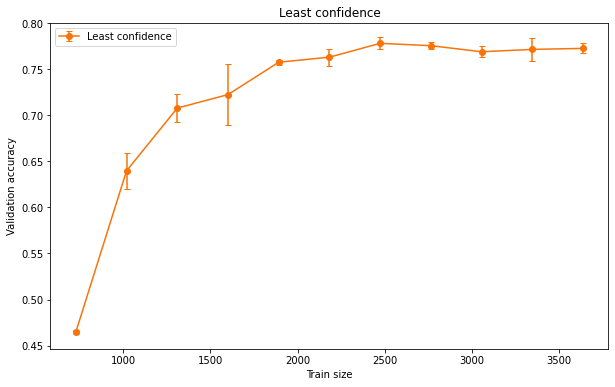

In [21]:
plot(
    lc_train_sizes, 
    lc_scores, 
    model_name="Least confidence", 
    color="xkcd:orange", 
    title="Least confidence"
)

### Entropy sampling

Idea: sample 10% examples with most entropy from the pool set on every step

In [22]:
%%time
%%capture
es_train_sizes, es_scores, es_aucs, es = run_exp(
    EntropySampling, 
    {
        "cfg": cfg, 
        "select_top_percent": SELECT_TOP_PERCENT, 
        "num_stochastic_forward_passes": NUM_STOCHASTIC_FORWARD_PASSES
    }, 
    init_data, 
    val_data,
    pool_data, 
    NUM_RUNS_PER_EXP
)

CPU times: user 15min 53s, sys: 46.4 s, total: 16min 40s
Wall time: 25min 45s


In [23]:
es_aucs

array([0.5815227 , 0.57520085, 0.57050336])

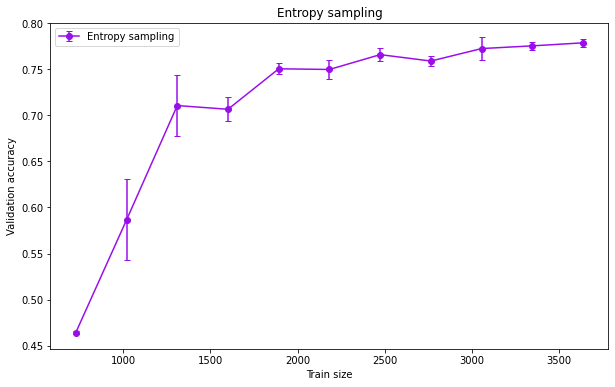

In [24]:
plot(
    es_train_sizes, 
    es_scores, 
    model_name="Entropy sampling", 
    color="xkcd:violet", 
    title="Entropy sampling"
)

### Margin Sampling

Idea: sample 10% examples with least difference between the highest probability and the second highest probability

In [25]:
%%time
%%capture
ms_train_sizes, ms_scores, ms_aucs, ms = run_exp(
    MarginSampling, 
    {
        "cfg": cfg, 
        "select_top_percent": SELECT_TOP_PERCENT, 
        "num_stochastic_forward_passes": NUM_STOCHASTIC_FORWARD_PASSES
    }, 
    init_data, 
    val_data,
    pool_data, 
    NUM_RUNS_PER_EXP
)

CPU times: user 16min 14s, sys: 46.5 s, total: 17min
Wall time: 25min 57s


In [26]:
ms_aucs

array([0.5815227 , 0.56282055, 0.58143489])

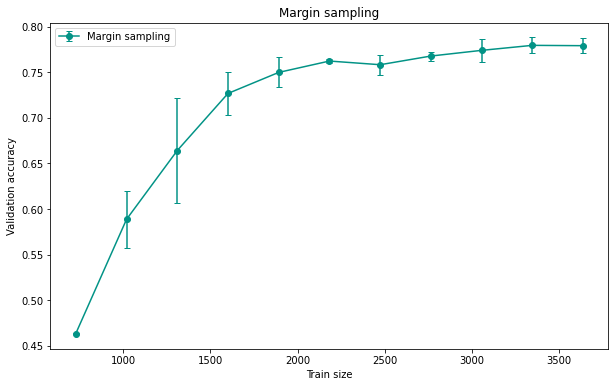

In [27]:
plot(
    ms_train_sizes, 
    ms_scores, 
    model_name="Margin sampling", 
    color="xkcd:teal", 
    title="Margin sampling"
)

### Variation Ratio

Idea: Variation Ratio is measure of dispersion around class: $1 - \frac{f_x}{T}$

- $f_x$ - most often predicted class count
- $T$ - number of stochastic forward passes

In [28]:
%%time
%%capture
vr_train_sizes, vr_scores, vr_aucs, vr = run_exp(
    VariationRatioSampling, 
    {
        "cfg": cfg, 
        "select_top_percent": SELECT_TOP_PERCENT, 
        "num_stochastic_forward_passes": NUM_STOCHASTIC_FORWARD_PASSES
    }, 
    init_data, 
    val_data,
    pool_data, 
    NUM_RUNS_PER_EXP
)

CPU times: user 16min 23s, sys: 50.7 s, total: 17min 14s
Wall time: 26min


In [29]:
vr_aucs

array([0.58380559, 0.58472753, 0.58038125])

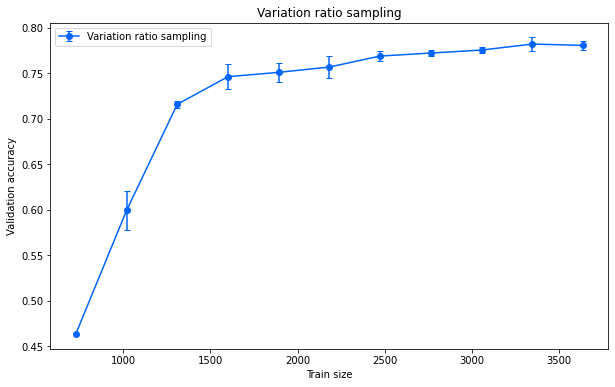

In [30]:
plot(
    vr_train_sizes, 
    vr_scores, 
    model_name="Variation ratio sampling", 
    color="xkcd:bright blue", 
    title="Variation ratio sampling"
)

### BALD

Description is here: [Overview of Active Learning for Deep Learning](https://jacobgil.github.io/deeplearning/activelearning#learning-loss-for-active-learning)

In [31]:
%%time
%%capture
bald_train_sizes, bald_scores, bald_aucs, bald = run_exp(
    BALDSampling, 
    {
        "cfg": cfg, 
        "select_top_percent": SELECT_TOP_PERCENT, 
        "num_stochastic_forward_passes": NUM_STOCHASTIC_FORWARD_PASSES
    }, 
    init_data, 
    val_data,
    pool_data, 
    NUM_RUNS_PER_EXP
)

CPU times: user 16min 22s, sys: 43.7 s, total: 17min 5s
Wall time: 25min 39s


In [32]:
bald_aucs

array([0.58336657, 0.58907381, 0.57730813])

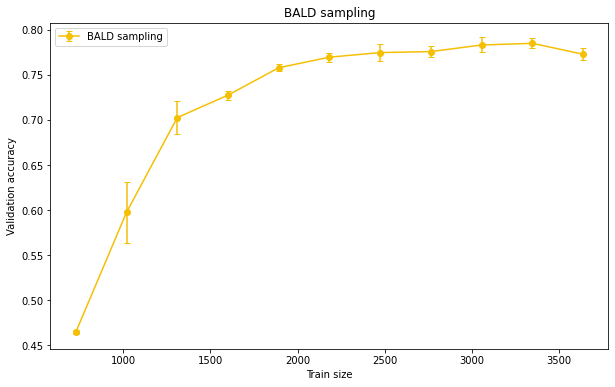

In [33]:
plot(
    bald_train_sizes, 
    bald_scores, 
    model_name="BALD sampling", 
    color="xkcd:golden", 
    title="BALD sampling"
)

### Comparison

In [34]:
results_table = pd.DataFrame.from_dict(
    {
        "name": [
            "random", "least confidence", "entropy", 
            "margin", "variation ratio", "BALD"
        ], 
        "auc": [
            rs_aucs.mean(), lc_aucs.mean(), es_aucs.mean(), 
            ms_aucs.mean(), vr_aucs.mean(), bald_aucs.mean()
        ]
    }
)

In [35]:
results_table

,name,auc
0,random,0.575245
1,least confidence,0.584054
2,entropy,0.575742
3,margin,0.575259
4,variation ratio,0.582971
5,BALD,0.583250


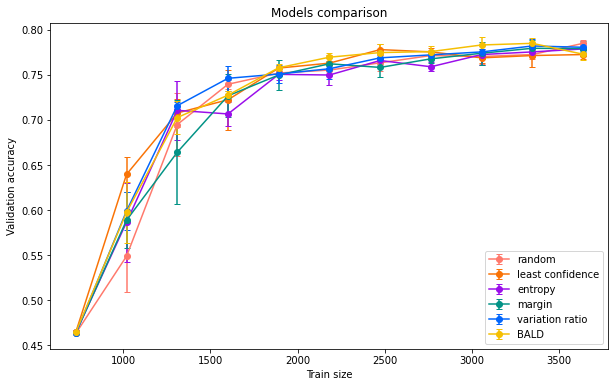

In [36]:
ys = [
    rs_scores, lc_scores, es_scores, 
    ms_scores, vr_scores, bald_scores
]
names = [
    "random", "least confidence", "entropy", 
    "margin", "variation ratio", "BALD"
]
colors = [
    "xkcd:salmon", "xkcd:orange", "xkcd:violet", 
    "xkcd:teal", "xkcd:bright blue", "xkcd:golden"
]

plot(
    vr_train_sizes, 
    ys, 
    model_name=names, 
    color=colors, 
    title="Models comparison"
)

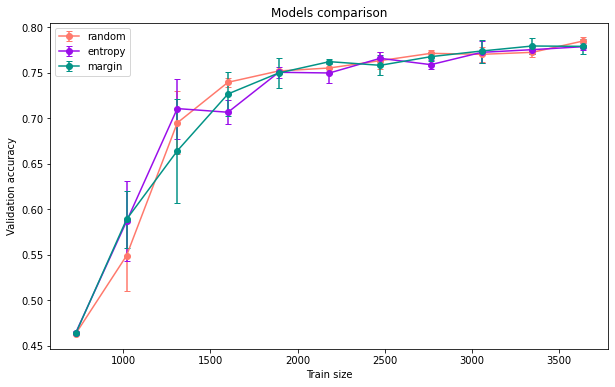

In [64]:
ys = [
    rs_scores, es_scores, ms_scores
]
names = [
    "random", "entropy", "margin"
]
colors = [
    "xkcd:salmon", "xkcd:violet", "xkcd:teal"
]

plot(
    vr_train_sizes, 
    ys, 
    model_name=names, 
    color=colors, 
    title="Models comparison"
)

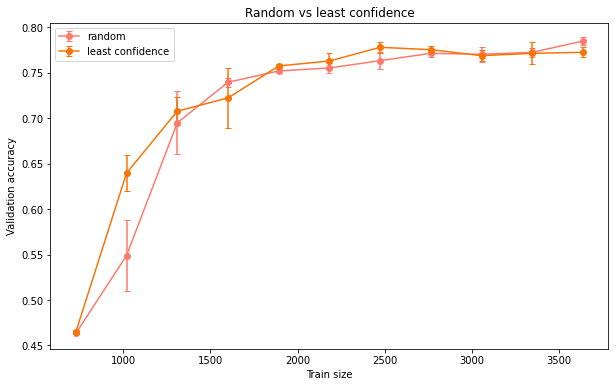

In [66]:
ys = [
    rs_scores, lc_scores
]
names = [
    "random", "variation ratio"
]
colors = [
    "xkcd:salmon", "xkcd:orange"
]

plot(
    vr_train_sizes, 
    ys, 
    model_name=names, 
    color=colors, 
    title="Random vs least confidence"
)

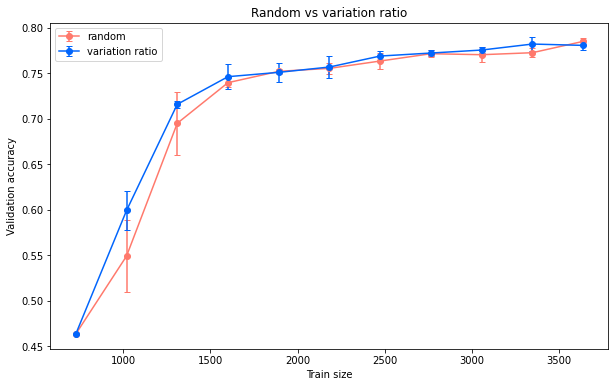

In [68]:
ys = [
    rs_scores, vr_scores
]
names = [
    "random", "variation ratio"
]
colors = [
    "xkcd:salmon", "xkcd:bright blue"
]

plot(
    vr_train_sizes, 
    ys, 
    model_name=names, 
    color=colors, 
    title="Random vs variation ratio"
)

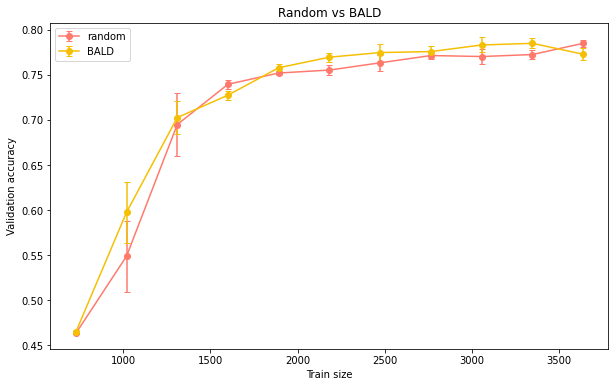

In [69]:
ys = [
    rs_scores, bald_scores
]
names = [
    "random", "BALD"
]
colors = [
    "xkcd:salmon", "xkcd:golden"
]

plot(
    vr_train_sizes, 
    ys, 
    model_name=names, 
    color=colors, 
    title="Random vs BALD"
)

Observations:

- Least confidence, variation ratio and BALD perform better than random sampling baseline. Entropy and margin show comparable results.
- Almost all method show better performance for small dataset sizes. Most difference in accuracy can be seen untill 2000 samples. All methods show comparable results for the following training sizes
- Quiery size schould be further explored with smaller select_top_percent. Also data redundacy heuristics could be applied.

Check examples selected by least confidence on the first step

In [43]:
lc.query_instances[0].head()

,title,sentiment,label,predicted_label_prob
2716,"Bitcoin, Ethereum, Ripple, Bitcoin Cash, EOS, ...",Neutral,1,0.337531
3635,"Bitcoin, Ethereum, Bitcoin Cash, Ripple, Stell...",Neutral,1,0.337831
687,"Bitcoin, Ethereum, Bitcoin Cash, Ripple, Stell...",Neutral,1,0.338248
3244,"Bitcoin, Ethereum, Ripple, Bitcoin Cash, EOS, ...",Neutral,1,0.339097
4351,"Bitcoin, Ethereum, Ripple, Bitcoin Cash, EOS, ...",Neutral,1,0.340009


In [44]:
lc.query_instances[0]["label"].value_counts()

1    163
0     92
2     36
Name: label, dtype: int64

In [49]:
le.classes_

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [60]:
lc.query_instances[0]["title"].head().values

array(['Bitcoin, Ethereum, Ripple, Bitcoin Cash, EOS, Stellar, Litecoin, Cardano, Monero, TRON: Price Analysis, October 8',
       'Bitcoin, Ethereum, Bitcoin Cash, Ripple, Stellar, Litecoin, Cardano, NEO, EOS: Price Analysis, March 16',
       'Bitcoin, Ethereum, Bitcoin Cash, Ripple, Stellar, Litecoin, Cardano, NEO, EOS: Price Analysis, March 26',
       'Bitcoin, Ethereum, Ripple, Bitcoin Cash, EOS, Stellar, Litecoin, Cardano, Monero, IOTA: Price Analysis, August 13',
       'Bitcoin, Ethereum, Ripple, Bitcoin Cash, EOS, Litecoin, Cardano, Stellar, IOTA, NEO: Price Analysis, July 06'],
      dtype=object)

Check examples selected by variation ratio on the first step

In [70]:
vr.query_instances[0].head()

,title,sentiment,label,variation_ratio
1132,Alleged Moolah Bitcoin Thief Ryan Kennedy Face...,Negative,0,0.5
2271,Authorities Arrest Indonesian Student Alleged ...,Negative,0,0.4
3516,Another Police Official Arrested In Alleged Bi...,Negative,0,0.4
4516,US Prosecutors Believe Ex-Secret Service Agent...,Negative,0,0.2
483,Bitcoin Bomb Threats Target Educational Instit...,Negative,0,0.2


In [54]:
vr.query_instances[0]["label"].value_counts()

0    129
2    107
1     55
Name: label, dtype: int64

In [55]:
le.classes_

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [58]:
vr.query_instances[0]["title"].head().values

array(['Alleged Moolah Bitcoin Thief Ryan Kennedy Faces First Court Hearing',
       'Authorities Arrest Indonesian Student Alleged to Have Purchased Ecstasy with Bitcoin from the Netherlands',
       'Another Police Official Arrested In Alleged Bitcoin Extortion Plot',
       'US Prosecutors Believe Ex-Secret Service Agent Stole More Bitcoin from Silk Road',
       'Bitcoin Bomb Threats Target Educational Institutions, Businesses and Govt. Buildings in US, Canada'],
      dtype=object)

Check examples selected by BALD on the first step

In [71]:
bald.query_instances[0].head()

,title,sentiment,label,mutual_information
1452,Major Food Delivery Portal Takeaway.com Accept...,Positive,2,0.006531
4160,Bitcoin is the Evil Spawn of the Financial Cri...,Negative,0,0.005539
713,Bitcoin Cash Price Technical Analysis BCH/USD...,Negative,0,0.004159
2609,Bitcoin Cash Briefly Surpasses the Market Cap ...,Positive,2,0.004144
4177,Bitcoin Price Will Hit New All-Time Highs in 2...,Positive,2,0.004095


In [72]:
bald.query_instances[0]["label"].value_counts()

2    137
0     90
1     64
Name: label, dtype: int64

In [73]:
le.classes_

array(['Negative', 'Neutral', 'Positive'], dtype=object)

In [74]:
bald.query_instances[0]["title"].head().values

array(['Major Food Delivery Portal Takeaway.com Accepts Bitcoin Across Europe',
       'Bitcoin is the Evil Spawn of the Financial Crisis: European Central Bank Board Member',
       'Bitcoin Cash Price Technical Analysis  BCH/USD Crashes Below $700',
       'Bitcoin Cash Briefly Surpasses the Market Cap of Ethereum at $30 Billion',
       'Bitcoin Price Will Hit New All-Time Highs in 2019: Quoine CEO'],
      dtype=object)